# Reparameterize simulations used for the emulator
For each simulation used in Rogers et al. (2019), read the GenIC parameter file and compute new parameters describing the linear power spectrum.

It can also read a precomputed file, and make plots.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import fit_pk
import read_genic

In [2]:
def plot_params(cosmologies,param1,param2):
    N=len(cosmologies)
    p1=np.empty(N)
    p2=np.empty(N)
    for i in range(N):
        cosmo=cosmologies[i]
        params=cosmo['cosmo_params']
        # check if param1 exists
        if param1 in params:
            p1[i]=params[param1]
        else:
            raise ValueError("could not find param1 "+param1)
        # check if param2 exists
        if param2 in params:
            p2[i]=params[param2]
        else:
            raise ValueError("could not find param2 "+param2)
            
    print(min(p1),'<',param1,'<',max(p1))
    print(min(p2),'<',param2,'<',max(p2))
    plt.figure()
    plt.scatter(p1,p2)
    plt.xlabel(param1)
    plt.ylabel(param2)

In [3]:
def add_linP_params(cosmo_params,linP_params):
    cosmo_params['f_star']=linP_params['f_star']
    cosmo_params['g_star']=linP_params['g_star']
    linP_kms=linP_params['linP_kms']
    cosmo_params['lnA_p']=linP_kms[0]
    cosmo_params['n_p']=linP_kms[1]
    cosmo_params['alpha_p']=linP_kms[2]

In [4]:
def add_derived_params(params,kp_kms):
    h=params['H0']/100.0
    params['h']=h
    ombh2=params['ombh2']
    omb=ombh2/h**2
    params['omb']=omb
    omch2=params['omch2']
    omc=omch2/h**2
    params['omc']=omc
    ombc=omb+omc
    params['ombc']=ombc
    # Delta_L^2 used in McDonald et al. (2005)
    lnA_p=params['lnA_p']
    params['DeltaL2']=np.exp(lnA_p)*kp_kms**3/(2*np.pi**2)
    # log(A_s)
    As=params['As']
    params['lnA_s']=np.log(As)
    return params

In [5]:
def cosmo_keys(cosmo):
    info='# name'
    params=cosmo['cosmo_params']
    for param in params.keys():
        info+=" %s" % param
    return info+'\n'

In [6]:
def cosmo_values(cosmo):
    info=cosmo['name']+' '
    params=cosmo['cosmo_params']
    for param in params.values():
        info+=" %f" % param
    return info+'\n'

In [7]:
def print_to_file(filename,cosmologies):
    with open(filename, "w") as text_file:
        header=cosmo_keys(cosmologies[0])
        text_file.write(header)
        for cosmo in cosmologies:
            info=cosmo_values(cosmo)
            text_file.write(info)

In [8]:
def read_from_file(filename):
    f = open(filename, "r")
    keys=None
    # will store parameters for all cosmologies
    cosmologies=[]
    for line in f:
        if keys is None:
            keys=line.split()[1:]
            Np=len(keys)
            print('will read %d parameters per model' % Np)
        else:
            cosmo={}
            cosmo_params={}
            params=line.split()
            if len(params) is not Np:
                raise ValueError("something went wrong while reading file %d != %d"%(len(params),Np))
            for key, param in zip(keys,params):
                if key == 'name':
                    cosmo['name']=param
                else:
                    cosmo_params[key]=float(param)
            # fix A_s 
            cosmo_params['As']=np.exp(cosmo_params['lnA_s'])
            cosmo['cosmo_params']=cosmo_params
            cosmologies.append(cosmo)
    return cosmologies

### Decide whether to read pre-computed file, or to compute linear power parameters for each simulation

In [9]:
read_file=True
if read_file:
    file_name='refinement_sims_parameters.txt'
    cosmologies=read_from_file(file_name)
    print('got %d cosmologies from file %s'%(len(cosmologies),file_name))
else:
    # identify simulations in folder
    sims_dir='refinement_genic_files/'
    genic_files=os.listdir(sims_dir)
    cosmologies=[]
    maxNsims=10
    Nsims=min(len(genic_files),maxNsims)
    for genic_file in genic_files[:Nsims]:
        # extract cosmological parameters from GenIC file
        cosmo_params = read_genic.camb_from_genic(sims_dir+genic_file)
        # setup CAMB object
        cosmo_camb = fit_pk.get_cosmology(cosmo_params)
        cosmo_dict = {'name':genic_file, 'cosmo_params':cosmo_params, 'cosmo_camb':cosmo_camb}
        cosmologies.append(cosmo_dict)
    # for each cosmology, compute linear power spectrum parameters
    z_star=3.0
    kp_kms=0.009
    N=len(cosmologies)
    for i in range(N):
        if (i%5 ==0):
            print('running cosmology %d out of %d'%(i,N))
        cosmo=cosmologies[i]
        linP_params = fit_pk.parameterize_cosmology(cosmo['cosmo_camb'],z_star=z_star,kp_kms=kp_kms)
        add_linP_params(cosmo['cosmo_params'],linP_params)
        add_derived_params(cosmo['cosmo_params'],kp_kms)
    print_to_file('test.txt',cosmologies)

will read 20 parameters per model
got 53 cosmologies from file refinement_sims_parameters.txt


### Make some plots comparing parameters in simulations

0.972913 < f_star < 0.98101
0.952679 < g_star < 0.967235


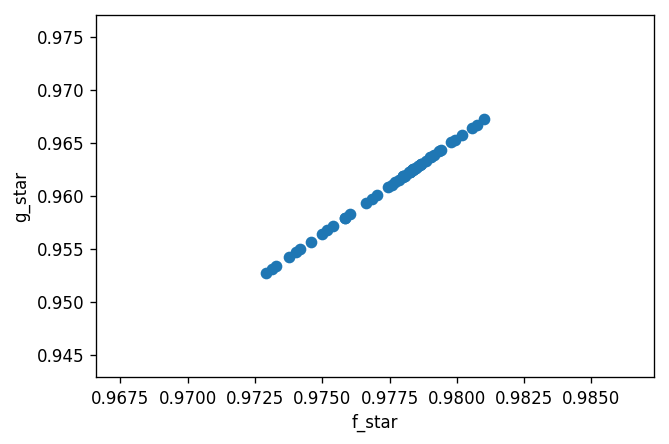

In [10]:
plot_params(cosmologies,'f_star','g_star')

0.972913 < f_star < 0.98101
0.23746 < ombc < 0.312638


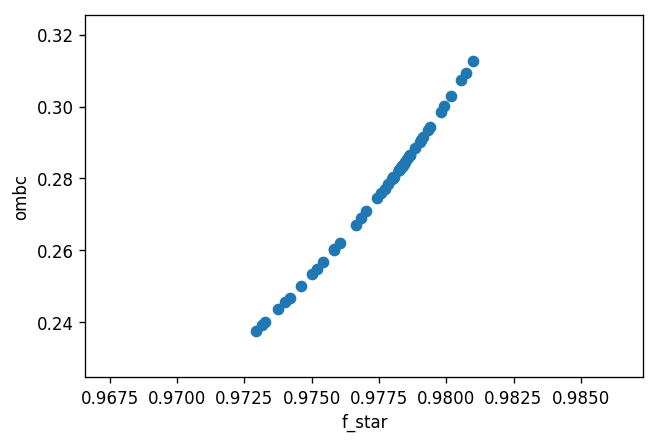

In [11]:
plot_params(cosmologies,'f_star','ombc')

0.902143 < ns < 0.989166
-2.384006 < n_p < -2.290936


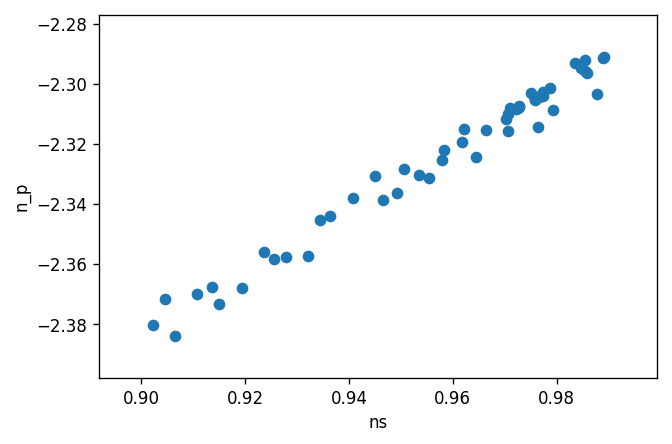

In [12]:
plot_params(cosmologies,'ns','n_p')

15.64659 < lnA_p < 16.295358
-20.235447 < lnA_s < -19.478898


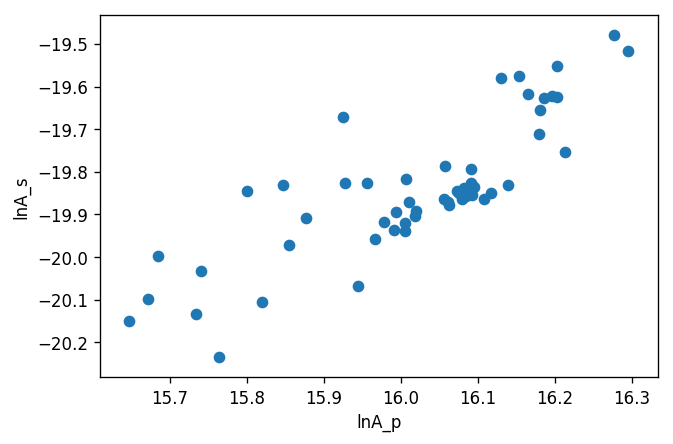

In [13]:
plot_params(cosmologies,'lnA_p','lnA_s')

0.230476 < DeltaL2 < 0.440942
-2.384006 < n_p < -2.290936


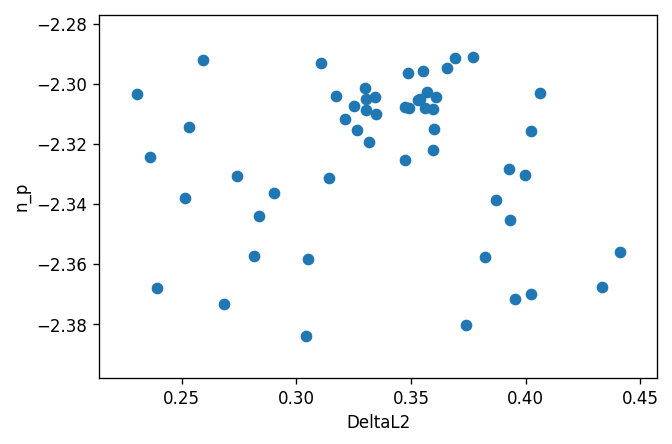

In [14]:
plot_params(cosmologies,'DeltaL2','n_p')